# Importing Libraries

In [2]:
# import system libraries
import os
import itertools
from PIL import Image
import cv2
from matplotlib.image import imread
import pathlib
import random

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Waring Library
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

## Read Data and store it in dataframe

In [3]:
data_dir = '/kaggle/input/flowers-dataset/flower_photos'
filepaths = []
labels = []

folders = os.listdir(data_dir)
for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [4]:
df

filepaths     labels
0     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
1     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
2     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
3     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
4     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
...                                                 ...        ...
3665  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3666  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3667  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3668  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3669  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips

[3670 rows x 2 columns]

In [5]:
# Visualize the number of classes count
df['labels'].value_counts()

labels
dandelion     898
tulips        799
sunflowers    699
roses         641
daisy         633
Name: count, dtype: int64

In [6]:
df['labels'].shape

(3670,)

## Visualize Flower Species

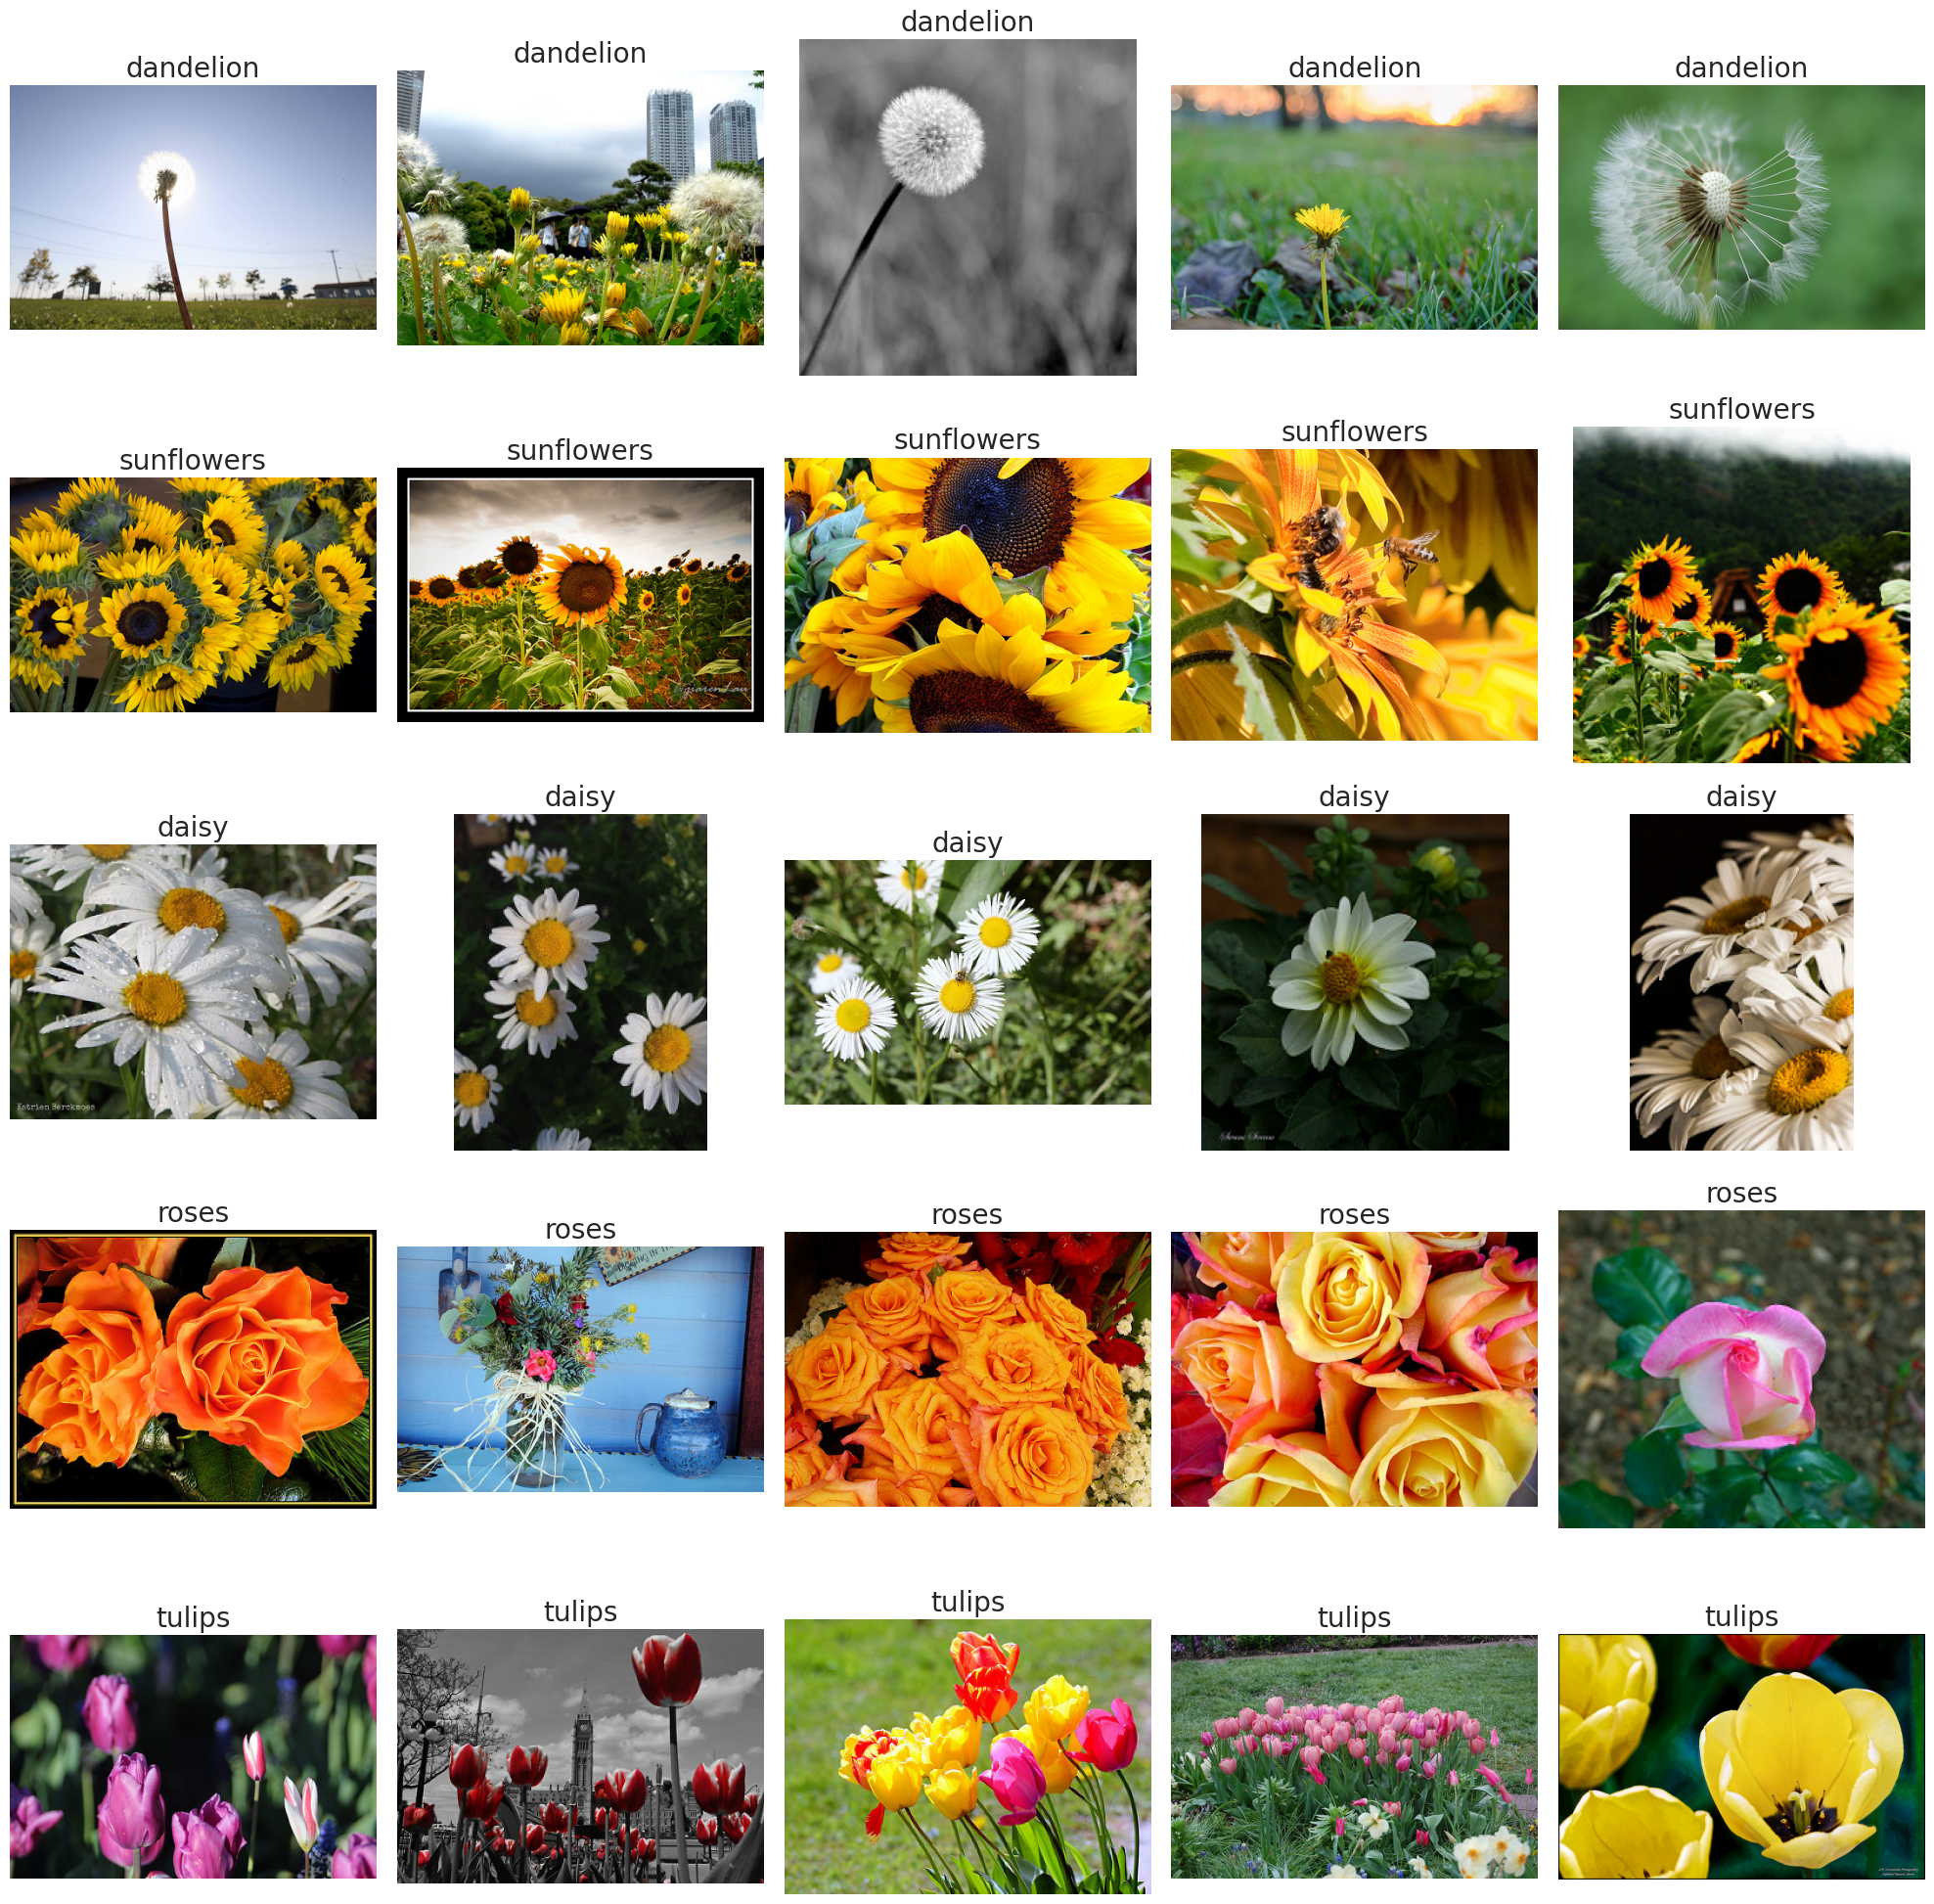

In [7]:
# Set the number of images to display per species
num_images = 5

# Get unique flower species labels
flower_species = df['labels'].unique()

# Set up the plot
plt.figure(figsize=(20, 20))

# Loop through each flower species
for idx, flower in enumerate(flower_species):
    # Filter the DataFrame to get file paths for this flower species
    flower_df = df[df['labels'] == flower].sample(num_images)  # Get a random sample of 16 images
    
    # Loop through the 16 images and plot them
    for i, file in enumerate(flower_df['filepaths'].values):
        plt.subplot(len(flower_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(flower)
        
# Show the plot
plt.tight_layout()
plt.show()

## Spliting the data into Training and Testing

In [8]:
# Splitting dataset
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=.3, random_state=123, stratify=strat, shuffle=True)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=.5, random_state=123, stratify=strat, shuffle=True)

In [9]:
train_df

filepaths     labels
3028  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
2407  /kaggle/input/flowers-dataset/flower_photos/ro...      roses
893   /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
2677  /kaggle/input/flowers-dataset/flower_photos/ro...      roses
3532  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
...                                                 ...        ...
2049  /kaggle/input/flowers-dataset/flower_photos/da...      daisy
2519  /kaggle/input/flowers-dataset/flower_photos/ro...      roses
2099  /kaggle/input/flowers-dataset/flower_photos/da...      daisy
3054  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3362  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips

[2569 rows x 2 columns]

In [10]:
print(f"Number of Training dataset: {len(train_df)}\nNumber of Validation dataset: {len(valid_df)}\nNumber of Testing dataset: {len(test_df)}")

Number of Training dataset: 2569
Number of Validation dataset: 550
Number of Testing dataset: 551


## Create image data generator

In [11]:
# crobed image size
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 2569 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Found 551 validated image filenames belonging to 5 classes.


# CNN

In [12]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [17]:
model = Sequential([
    Conv2D(16, 3, activation='relu', padding='same', input_shape=img_shape),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(class_count, activation='softmax')
    
])

model.compile(Adamax(learning_rate=.0001), loss='categorical_crossentropy', metrics=['acc'])

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761,941 (10.54 MB)

 Trainable params: 2,761,941 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)

plateau = ReduceLROnPlateau(
    patience=4,
    mode=min,
    monitor='val_loss',
    factor=.2,
    verbose=0
)

In [20]:
history = model.fit(x= train_gen, verbose=1, validation_data=valid_gen,
                        epochs=1000, callbacks=[early_stopping, plateau])

Epoch 1/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - acc: 0.2610 - loss: 1.5855 - val_acc: 0.4145 - val_loss: 1.2958 - learning_rate: 1.0000e-04
Epoch 2/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - acc: 0.4515 - loss: 1.2513 - val_acc: 0.5382 - val_loss: 1.1410 - learning_rate: 1.0000e-04
Epoch 3/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - acc: 0.5537 - loss: 1.1163 - val_acc: 0.5836 - val_loss: 1.0824 - learning_rate: 1.0000e-04
Epoch 4/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - acc: 0.5865 - loss: 1.0265 - val_acc: 0.5891 - val_loss: 1.0730 - learning_rate: 1.0000e-04
Epoch 5/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - acc: 0.5935 - loss: 1.0113 - val_acc: 0.6091 - val_loss: 1.0298 - learning_rate: 1.0000e-04
Epoch 6/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - acc: 0.6287 - loss: 0.9403 - val_acc: 0.6073 - val_loss: 0.9778 - learning_rate: 1.0000e-04
Epoch 7/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - acc: 0.6344 - loss: 0.9086 - val_acc: 0.5873 - val_loss

## Display model performance

In [21]:
# Define needed variables
tr_acc = history.history['acc']
tr_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

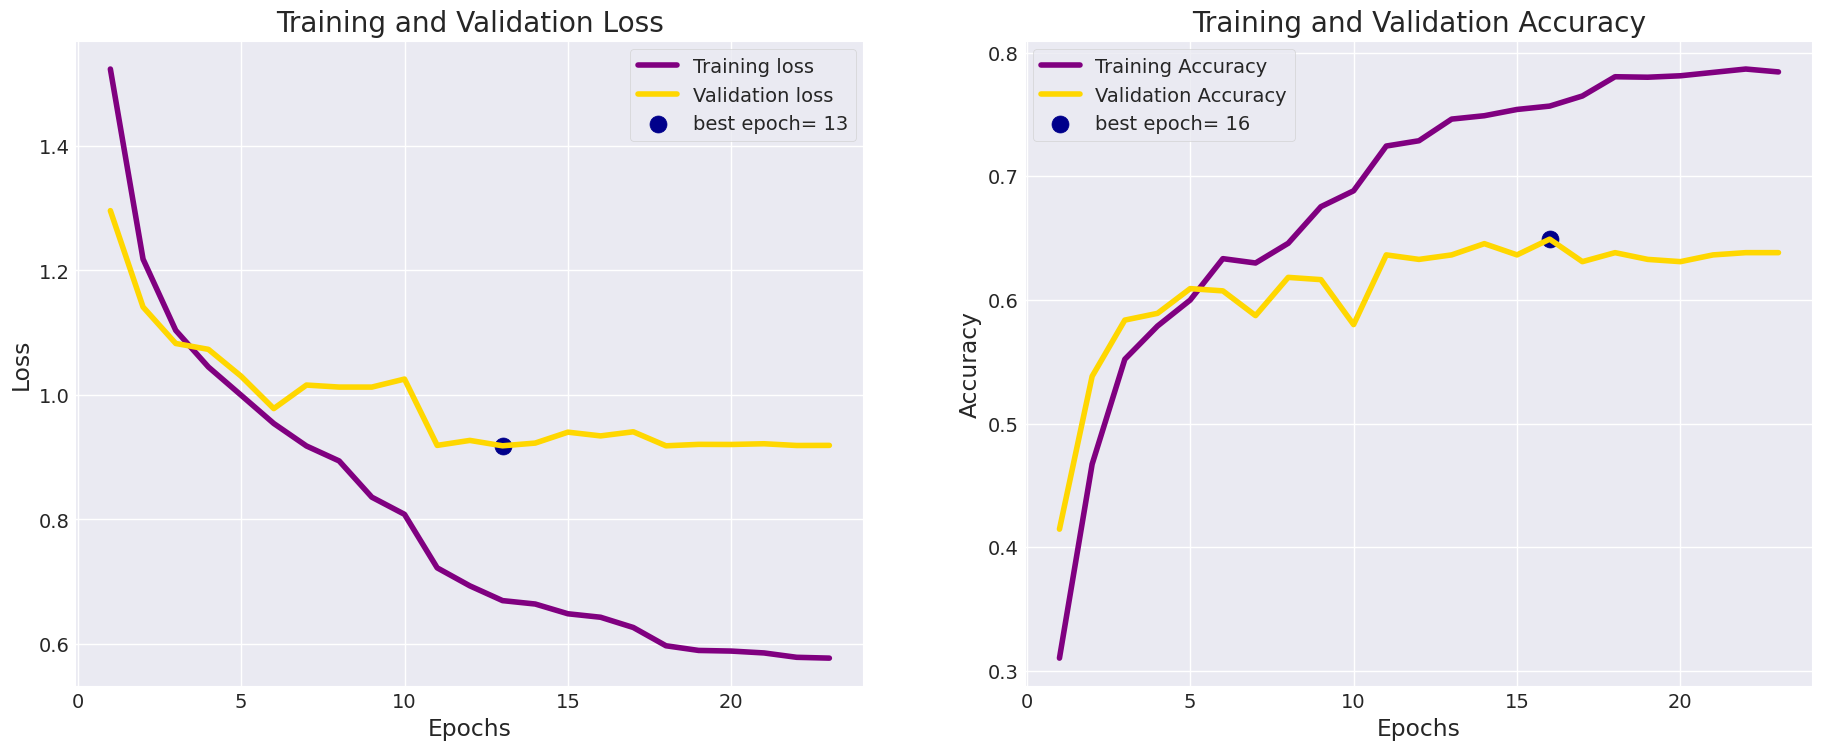

In [22]:
# Plot training history
plt.figure(figsize= (20, 8))

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# After Data Augmantation

In [23]:
# Parameters
batch_size = 32
img_size = (224, 224)  # Image size (cropped size)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Data augmentation for the training data
tr_gen = ImageDataGenerator(
    rotation_range=20,           # Rotate images up to 20 degrees
    width_shift_range=0.2,       # Shift images horizontally (20% of width)
    height_shift_range=0.2,      # Shift images vertically (20% of height)
    shear_range=0.2,             # Shearing transformation
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill mode for pixels outside boundaries
)

# No augmentation for validation/test data, just rescaling
ts_gen = ImageDataGenerator()

# Generate training, validation, and test batches
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',target_size=img_size, class_mode='categorical', 
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 2569 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Found 551 validated image filenames belonging to 5 classes.


## CNN Model

In [26]:
model2 = Sequential([
#     Conv2D(32, 3, activation='relu', padding='same', input_shape=img_shape),
#     Conv2D(32, 3, activation='relu', padding='same'),
#     MaxPooling2D((2,2)),
    
    Conv2D(64, 3, activation='relu', padding='same', input_shape=img_shape),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(512, 3, activation='relu', padding='same'),
    Conv2D(512, 3, activation='relu', padding='same'),
    Conv2D(512, 3, activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(class_count, activation='softmax')
    
])

model2.compile(Adamax(learning_rate=.0001), loss='categorical_crossentropy', metrics=['acc'])

In [27]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,248,069 (54.35 MB)

 Trainable params: 14,248,069 (54.35 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)

plateau = ReduceLROnPlateau(
    patience=4,
    mode=min,
    monitor='val_loss',
    factor=.2,
    verbose=0
)

In [29]:
history2 = model2.fit(x= train_gen, verbose=1, validation_data=valid_gen,
                        epochs=1000, callbacks=[early_stopping, plateau])

Epoch 1/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 64s 500ms/step - acc: 0.2907 - loss: 1.5319 - val_acc: 0.4400 - val_loss: 1.2275 - learning_rate: 1.0000e-04
Epoch 2/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 388ms/step - acc: 0.4746 - loss: 1.1995 - val_acc: 0.5273 - val_loss: 1.2135 - learning_rate: 1.0000e-04
Epoch 3/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - acc: 0.5333 - loss: 1.1377 - val_acc: 0.5073 - val_loss: 1.1361 - learning_rate: 1.0000e-04
Epoch 4/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 387ms/step - acc: 0.5590 - loss: 1.0832 - val_acc: 0.5891 - val_loss: 1.0812 - learning_rate: 1.0000e-04
Epoch 5/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 395ms/step - acc: 0.5644 - loss: 1.0711 - val_acc: 0.5836 - val_loss: 1.0562 - learning_rate: 1.0000e-04
Epoch 6/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 387ms/step - acc: 0.5787 - loss: 1.0187 - val_acc: 0.6255 - val_loss: 0.9871 - learning_rate: 1.0000e-04
Epoch 7/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 388ms/step - acc: 0.6464 - loss: 0.9355 - val_acc: 0.6727 - va

## Display model performance

In [30]:
# Define needed variables
tr_acc = history2.history['acc']
tr_loss = history2.history['loss']
val_acc = history2.history['val_acc']
val_loss = history2.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

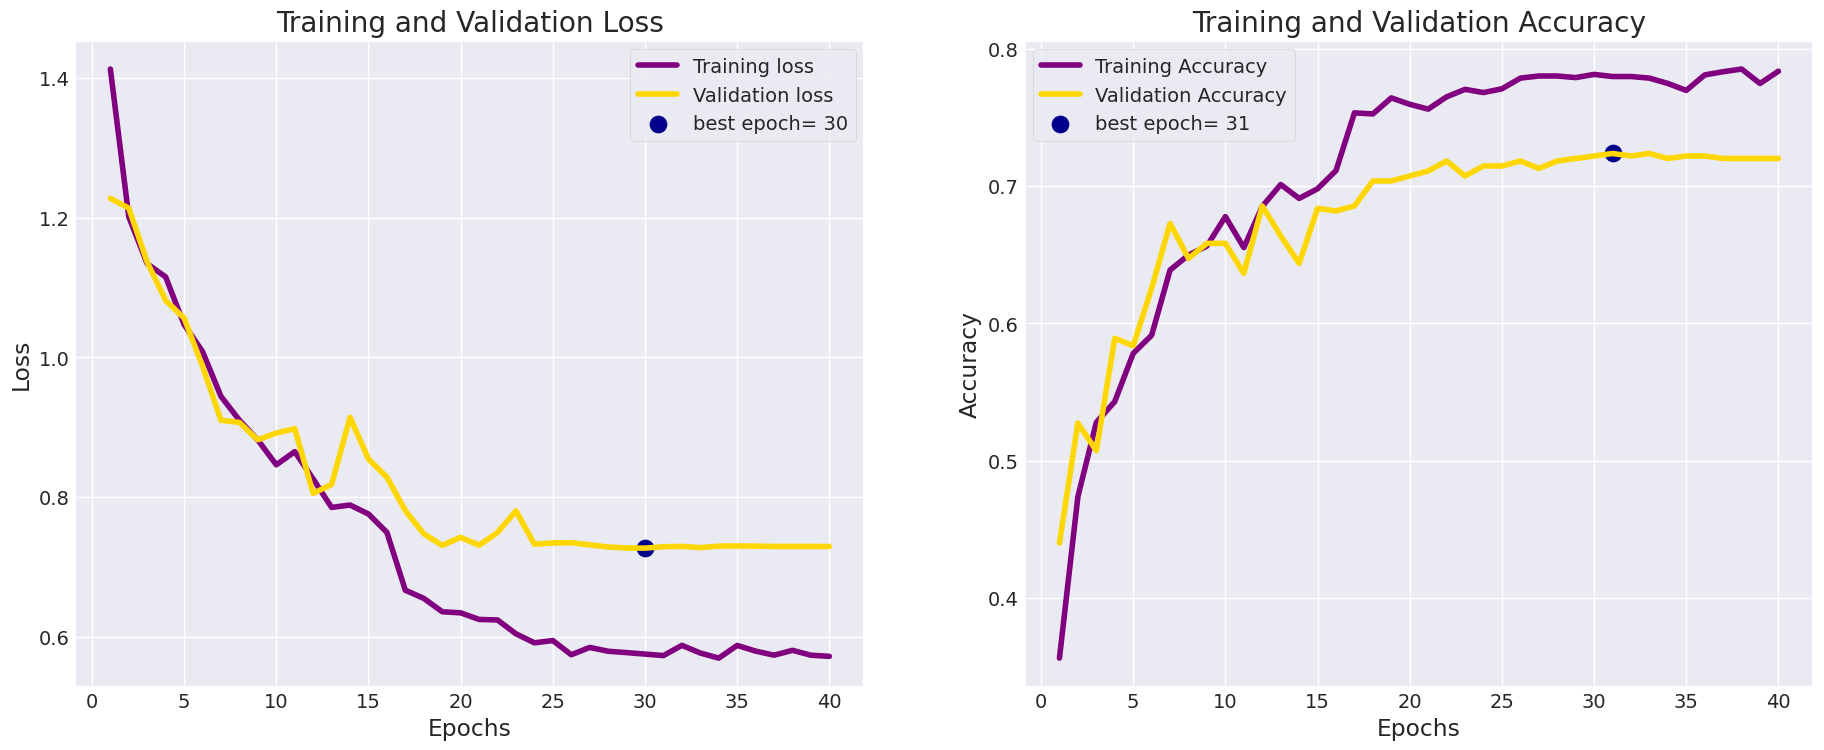

In [31]:
# Plot training history
plt.figure(figsize= (20, 8))

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [32]:
train_score = model2.evaluate(train_gen, verbose= 1)
valid_score = model2.evaluate(valid_gen, verbose= 1)
test_score = model2.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 393ms/step - acc: 0.7735 - loss: 0.5873
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - acc: 0.7296 - loss: 0.7070
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - acc: 0.7431 - loss: 0.7804
Train Loss:  0.5646653175354004
Train Accuracy:  0.7808485627174377
--------------------
Valid Loss:  0.7268956303596497
Valid Accuracy:  0.721818208694458
--------------------
Test Loss:  0.7647759914398193
Test Accuracy:  0.7350271940231323


# Get Predictions

In [33]:
preds  = model2.predict(test_gen)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


In [34]:
y_pred = np.argmax(preds, axis=1)
y_pred

array([3, 1, 2, 3, 3, 0, 0, 0, 2, 2, 3, 4, 2, 4, 4, 2, 3, 4, 1, 2, 3, 0,
       4, 2, 0, 2, 4, 1, 0, 1, 1, 1, 1, 2, 3, 0, 3, 0, 4, 2, 1, 2, 2, 2,
       0, 0, 1, 2, 3, 2, 0, 0, 4, 4, 3, 4, 1, 3, 2, 3, 1, 4, 1, 3, 2, 2,
       3, 2, 1, 4, 3, 4, 1, 4, 4, 2, 4, 2, 3, 3, 2, 1, 4, 3, 4, 2, 0, 3,
       4, 1, 1, 4, 3, 0, 4, 0, 2, 4, 2, 3, 1, 4, 2, 0, 1, 4, 1, 1, 4, 3,
       3, 2, 4, 0, 2, 1, 1, 3, 1, 3, 1, 2, 0, 0, 0, 3, 1, 3, 4, 2, 1, 0,
       0, 0, 1, 3, 0, 4, 1, 1, 2, 3, 0, 1, 0, 1, 3, 2, 1, 4, 2, 2, 3, 1,
       4, 4, 3, 1, 3, 1, 4, 0, 1, 1, 0, 2, 3, 2, 0, 4, 4, 4, 3, 1, 4, 3,
       1, 3, 4, 1, 0, 1, 0, 1, 0, 1, 2, 2, 3, 0, 4, 0, 4, 1, 3, 4, 0, 4,
       0, 4, 1, 3, 1, 3, 3, 1, 4, 1, 1, 4, 3, 3, 3, 1, 3, 1, 0, 4, 2, 1,
       4, 4, 1, 1, 2, 0, 1, 3, 0, 2, 2, 3, 0, 1, 3, 0, 0, 2, 0, 2, 3, 1,
       3, 0, 4, 2, 2, 4, 1, 1, 4, 4, 3, 1, 4, 0, 1, 4, 3, 4, 1, 2, 0, 1,
       1, 1, 3, 0, 0, 3, 1, 3, 3, 0, 1, 3, 1, 4, 0, 0, 0, 3, 2, 1, 3, 4,
       1, 3, 3, 3, 3, 1, 4, 2, 4, 3, 1, 3, 2, 1, 0,

In [35]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

In [36]:
g_dict

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [37]:
classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [40]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[ 65,  11,   6,   5,   8],
       [  9, 107,   3,  11,   5],
       [  7,  10,  65,   1,  13],
       [  3,   8,   3,  86,   5],
       [  6,   7,  15,  10,  82]])

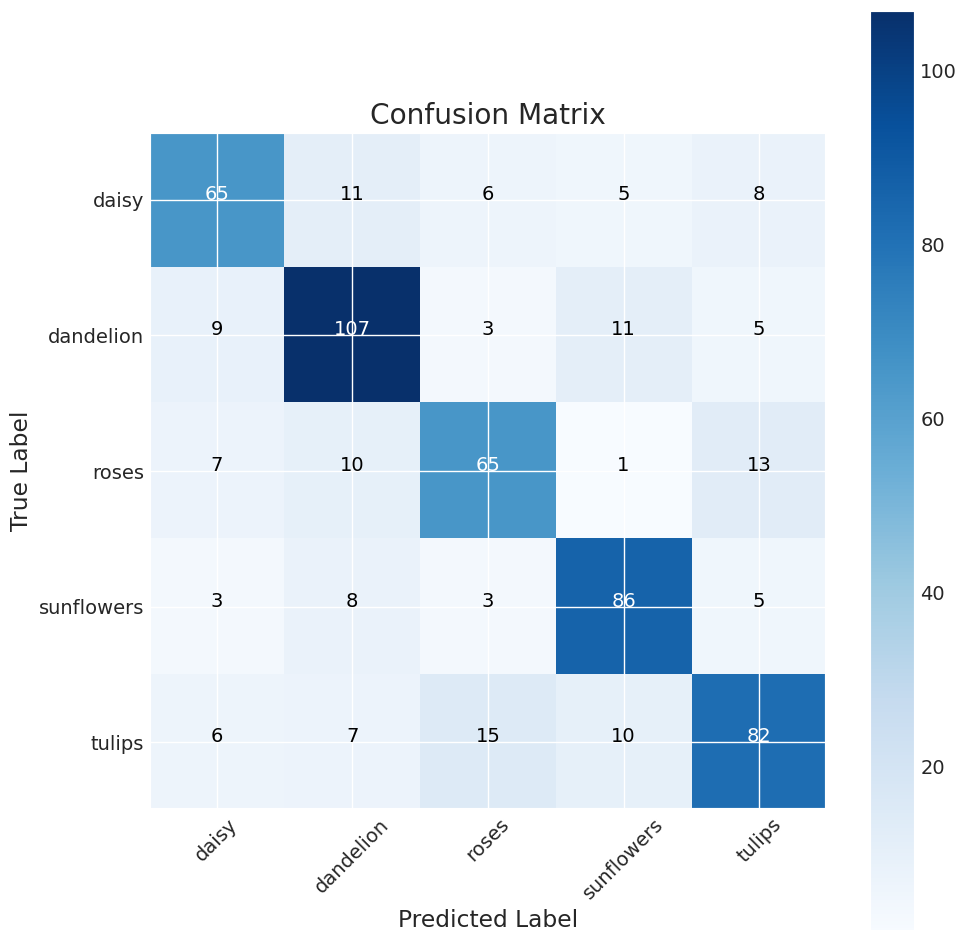

In [41]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [42]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       daisy       0.72      0.68      0.70        95
   dandelion       0.75      0.79      0.77       135
       roses       0.71      0.68      0.69        96
  sunflowers       0.76      0.82      0.79       105
      tulips       0.73      0.68      0.70       120

    accuracy                           0.74       551
   macro avg       0.73      0.73      0.73       551
weighted avg       0.73      0.74      0.73       551



# Save Model

In [43]:
#Save the model
model.save('Flower_Model_CNN.h5')